In [ ]:
import warnings
warnings.filterwarnings('ignore') 
import spacy
nlp = spacy.load('de_core_news_sm')
from spacy.tokenizer import Tokenizer
from spacy.tokens import Doc
import re
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
#Prüfen ob GPU verwendet wird
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

In [ ]:
words = []
annotations = []

try:
    fh = open("/Users/marku/Downloads/corpus_part_Deli.txt", encoding="UTF-8")
    
    for line_num, line_txt in enumerate(fh, start=1):
        if line_num %2 == 1:
            words.append(line_txt.strip())
        else:
            annotations.append(line_txt.strip())
    fh.close()
except IOError:
    print("Could not read file")

print("# Äußerungen: ", len(words))
print("# Annotationen: ", len(annotations))

# Äußerungen:  349
# Annotationen:  349


In [ ]:
text = []
incorrect_annotations = []
doc_id = 0
annotations_in_use = ""
initial_tags = []

for doc in nlp.pipe(words):
    tokens = []
    for token in doc:
        tokens.append(token.lemma_)
    tags = annotations[doc_id].split()
    initial_tags.append(tags[0])
    if len(tokens) == len(tags):
        for t in range(len(tokens)):
            text.append(tokens[t].lower() + " " + tags[t])
            annotations_in_use = annotations_in_use + " " + annotations[doc_id]
    else:
        print(2*(doc_id+1), len(tokens), len(tags))
        incorrect_annotations.append(doc_id)
    doc_id = doc_id + 1
print("Fehler in der Annotation bei folgenden Äußerungen: ", incorrect_annotations)
print(sorted(set(annotations_in_use.split())))

Fehler in der Annotation bei folgenden Äußerungen:  []
['B-Beurteilung,Bewertung,Gutachten,Wertung', 'B-Dauer', 'B-Ende,Endstück', 'B-Essen,Esswaren,Eßwaren,Lebensmittel,Nahrung,Nahrungsmittel,Speisen', 'B-Forum,Plattform', 'B-GemüseSahnesoße', 'B-Gericht:Gemüsesoße', 'B-Gericht:Sauce', 'B-Geschmacksträger', 'B-Gewürz', 'B-Kategorie:Aufläufe', 'B-Kategorie:Curry', 'B-Kategorie:Flüssigkeit', 'B-Kategorie:Gemüse', 'B-Kategorie:Gewürze', 'B-Kategorie:Kuchen', 'B-Kategorie:Milchprodukte', 'B-Kategorie:Pasta', 'B-Kategorie:Resteküche', 'B-Kategorie:Rezept', 'B-Kategorie:Rezepte', 'B-Kategorie:Rührei', 'B-Kategorie:Sahne', 'B-Kategorie:Sahnesauce', 'B-Kategorie:Salat', 'B-Kategorie:Sauce', 'B-Kategorie:Video', 'B-Kategorie:Zutaten', 'B-Knollen-Ziest', 'B-Kommentar,Kommentierung', 'B-Kraft', 'B-Liter,Maß', 'B-Menge', 'B-Menge:Brühe', 'B-Menge:Gramm', 'B-Menge:Milliliter', 'B-Menge:Personen', 'B-Menge:Zentimeter', 'B-Negation', 'B-Personen', 'B-Pfeffer', 'B-Punkt', 'B-Rezept', 'B-Rezept,Zubere

In [ ]:
# Aufgabe 2

In [ ]:
wordsLemma = []
for doc in nlp.pipe(words):
    tokens = []
    for token in doc:
        tokens.append(token.lemma_.lower())
    wordsLemma.append(tokens)

In [ ]:
dataset = []
countSentence = 0
for sentence in wordsLemma:
    countElement = 0
    anno = re.sub(':[A-Z|a-z|0-9|ä|ü|ö|ß]*', '', annotations[countSentence]).split()
    for element in sentence:
        tuples = []
        tuples.append(countSentence)
        tuples.append(element)
        tuples.append(anno[countElement])
        countElement += 1
        dataset.append(tuples)
    countSentence += 1

In [ ]:
sentenceLengthList = []
count = 0
lastNumber = 0
for element in dataset:
    if(element[0] == lastNumber):
        count += 1
    else:
        sentenceLengthList.append(count)
        count = 1
        lastNumber += 1
sentenceLengthList.append(count)

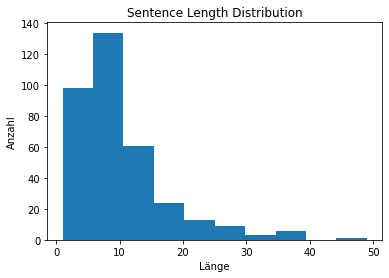

In [ ]:
numbers = np.array(sentenceLengthList) #Länge der Sätzte bestimmen, um Zielgröße für Padding fest zu legen
plt.hist(numbers)
plt.title("Sentence Length Distribution")
plt.xlabel("Länge")
plt.ylabel("Anzahl")
plt.show()

In [ ]:
maxSentenceLength = 50 #Post Padding auf Satzlänge 50
newDataset = []
countSentence = 0
countIndex = 0
count = 0
for liste in sentenceLengthList:
    for i in range(maxSentenceLength):
        tuples = []
        if  i < liste:
            tuples.append(countSentence)
            tuples.append(dataset[count][1])
            tuples.append(dataset[count][2])
            newDataset.append(tuples)
            count += 1
        else:
            tuples.append(countSentence)
            tuples.append('PADword')
            tuples.append('O')
            newDataset.append(tuples)
    countSentence += 1  

In [ ]:
df = DataFrame (newDataset, columns=['Sentence', 'Word', 'Annotation'])

In [ ]:
Words = list(set(df['Word'].values)) #Wort/Tag Liste und Größe des Vocabs/Tags
n_words = len(Words); 
tags = list(set(df["Annotation"].values))
n_tags = len(tags);

In [ ]:
count = 0 #Anlegen einer Liste mit den X-Werten
listX = []
tmp = []
for i in range (len(df['Word'])): 
    if count < maxSentenceLength:
        tmp.append(newDataset[i][1])
    else:
        count = 0
        listX.append(tmp)
        tmp = []
        tmp.append(newDataset[i][1])
    count += 1

In [ ]:
count = 0 #Anlegen einer Liste mit den Y-Werten
listY = []
tmp = []
for i in range (len(df['Annotation'])): 
    if count < maxSentenceLength:
        tmp.append(newDataset[i][2])
    else:
        count = 0
        listY.append(tmp)
        tmp = []
        tmp.append(newDataset[i][2])
    count += 1

In [ ]:
#Tagdict anlegen
tags2index = {t:i for i,t in enumerate(tags)}

y = []
for element in listY:
    tmp = []
    for token in element:
        tmp.append(tags2index[token])
    y.append(tmp)

y = [to_categorical(i, num_classes=n_tags) for i in y]

In [ ]:
#Wortdict anlegen
words2index = {w:i + 1 for i, w in enumerate(Words)}

X = []
for element in listX:
    tmp = []
    for word in element:
        tmp.append(words2index[word])
    X.append(tmp)

In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.1, random_state=420) 

In [ ]:
input = Input(shape=(maxSentenceLength,))
model = Embedding(input_dim=n_words , output_dim=20, #Embedding mit 20 Dim Output
                input_length=maxSentenceLength)(input)
model = Bidirectional(LSTM(units=256, return_sequences=True,
                           recurrent_dropout=0.4))(model)  #bi-LSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  #dense layer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output
model = Model(input, out)

In [ ]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])#Modell komplilieren
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 20)            10680     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 512)           567296    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 50)            25650     
_________________________________________________________________
crf_1 (CRF)                  (None, 50, 239)           69788     
Total params: 673,414
Trainable params: 673,414
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=10, epochs=25,#Modell trainieren 
                    validation_split=0.1, verbose=1)


Train on 281 samples, validate on 32 samples
Epoch 1/250
281/281 [==============================] - 8s 29ms/step - loss: 1.1894 - crf_viterbi_accuracy: 0.8471 - val_loss: 0.5268 - val_crf_viterbi_accuracy: 0.9370
Epoch 2/250
281/281 [==============================] - 13s 45ms/step - loss: 0.4669 - crf_viterbi_accuracy: 0.9360 - val_loss: 0.4534 - val_crf_viterbi_accuracy: 0.9370
Epoch 3/250
281/281 [==============================] - 6s 22ms/step - loss: 0.4291 - crf_viterbi_accuracy: 0.9317 - val_loss: 0.4838 - val_crf_viterbi_accuracy: 0.9370
Epoch 4/250
281/281 [==============================] - 6s 22ms/step - loss: 0.4111 - crf_viterbi_accuracy: 0.9334 - val_loss: 0.4595 - val_crf_viterbi_accuracy: 0.9370
Epoch 5/250
281/281 [==============================] - 6s 21ms/step - loss: 0.4005 - crf_viterbi_accuracy: 0.9329 - val_loss: 0.4670 - val_crf_viterbi_accuracy: 0.9370
Epoch 6/250
281/281 [==============================] - 6s 20ms/step - loss: 0.3906 - crf_viterbi_accuracy: 0.9348

In [ ]:
# Aufgabe 3

In [ ]:
dataset2 = [] #Neues Dataset da nun nur noch Values von Tag
countSentence = 0
for sentence in wordsLemma:
    countElement = 0
    anno = re.sub('[A-Z]-[A-Z|a-z|-|ä|Ä|ü|Ü|ö|ö|ß|,|0-9]*:', '', annotations[countSentence]).split()
    for element in sentence:
        tuples = []
        tuples.append(countSentence)
        tuples.append(element)
        tuples.append(anno[countElement])
        countElement += 1
        dataset2.append(tuples)
    countSentence += 1

In [ ]:
tmp1 = [] #Tags ohne Value durch 'O' ersetzen
for liste in dataset2:
    tmp2 = []
    for element in liste:
        if isinstance(element, str):
            if element.startswith('B-'):
                tmp2.append('O')
            elif element.startswith('I-'):
                tmp2.append('O')
            else:
                tmp2.append(element)
        else:
            tmp2.append(element)
    tmp1.append(tmp2)
dataset2 = tmp1

In [ ]:
maxSentenceLength = 50 #Post Padding
newDataset2 = []
countSentence = 0
countIndex = 0
count = 0
for liste in sentenceLengthList:
    for i in range(maxSentenceLength):
        tuples = []
        if  i < liste:
            tuples.append(countSentence)
            tuples.append(dataset2[count][1])
            tuples.append(dataset2[count][2])
            newDataset2.append(tuples)
            count += 1
        else:
            tuples.append(countSentence)
            tuples.append('PADword')
            tuples.append('O')
            newDataset2.append(tuples) 
    countSentence += 1  

In [ ]:
df2 = DataFrame (newDataset2, columns=['Sentence', 'Word', 'Annotation'])

In [ ]:
Words2 = list(set(df2['Word'].values)) #Wort/Tag Liste und Größe des Vocabs/Tags
n_words2 = len(Words2); 
tags2 = list(set(df2["Annotation"].values))
n_tags2 = len(tags2);

In [ ]:
count = 0 #Anlegen einer Liste mit den X-Werten
listX2 = []
tmp = []
for i in range (len(df2['Word'])): 
    if count < maxSentenceLength:
        tmp.append(newDataset2[i][1])
    else:
        count = 0
        listX2.append(tmp)
        tmp = []
        tmp.append(newDataset2[i][1])
    count += 1

In [ ]:
count = 0 #Anlegen einer Liste mit den Y-Werten
listY2 = []
tmp = []
for i in range (len(df2['Annotation'])): 
    if count < maxSentenceLength:
        tmp.append(newDataset2[i][2])
    else:
        count = 0
        listY2.append(tmp)
        tmp = []
        tmp.append(newDataset2[i][2])
    count += 1

In [ ]:
#Tag Dict erstellen
tags2index2 = {t:i for i,t in enumerate(tags2)}

y2 = []
for element in listY2:
    tmp = []
    for token in element:
        tmp.append(tags2index2[token])
    y2.append(tmp)

y2 = [to_categorical(i, num_classes=n_tags2) for i in y2]

In [ ]:
#### Wort Dict erstellen
words2index2 = {w:i + 1 for i, w in enumerate(Words2)}

X2 = []
for element in listX2:
    tmp = []
    for word in element:
        tmp.append(words2index2[word])
    X2.append(tmp)

In [ ]:
#Train test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(np.array(X2), np.array(y2), test_size=0.1, random_state=42)

In [ ]:
input = Input(shape=(maxSentenceLength,))
model2 = Embedding(input_dim=n_words2, output_dim=20, #Embedding mit 20 Dim Output
                input_length=maxSentenceLength)(input)
model2 = Bidirectional(LSTM(units=256, return_sequences=True,
                           recurrent_dropout=0.3))(model2)  #bi-LSTM
model2 = TimeDistributed(Dense(50, activation="relu"))(model2)  #dense layer
crf = CRF(n_tags2)  #CRF layer
out = crf(model2)  #output
model2 = Model(input, out)

In [ ]:
model2.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])#Modell komplilieren
model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 20)            10680     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 512)           567296    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 50)            25650     
_________________________________________________________________
crf_3 (CRF)                  (None, 50, 152)           31160     
Total params: 634,786
Trainable params: 634,786
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model2.fit(np.array(X_train2), np.array(y_train2), batch_size=10, epochs=25,#Modell trainieren
                    validation_split=0.1, verbose=1)

Train on 281 samples, validate on 32 samples
Epoch 1/200
281/281 [==============================] - 7s 25ms/step - loss: 0.8108 - crf_viterbi_accuracy: 0.9174 - val_loss: 0.3247 - val_crf_viterbi_accuracy: 0.9670
Epoch 2/200
281/281 [==============================] - 5s 17ms/step - loss: 0.2930 - crf_viterbi_accuracy: 0.9634 - val_loss: 0.3121 - val_crf_viterbi_accuracy: 0.9670
Epoch 3/200
281/281 [==============================] - 5s 17ms/step - loss: 0.2741 - crf_viterbi_accuracy: 0.9628 - val_loss: 0.3197 - val_crf_viterbi_accuracy: 0.9670
Epoch 4/200
281/281 [==============================] - 5s 19ms/step - loss: 0.2632 - crf_viterbi_accuracy: 0.9646 - val_loss: 0.3063 - val_crf_viterbi_accuracy: 0.9670
Epoch 5/200
281/281 [==============================] - 5s 18ms/step - loss: 0.2492 - crf_viterbi_accuracy: 0.9634 - val_loss: 0.2997 - val_crf_viterbi_accuracy: 0.9670
Epoch 6/200
281/281 [==============================] - 5s 18ms/step - loss: 0.2374 - crf_viterbi_accuracy: 0.9647 -

In [ ]:
#Aufgabe 4

In [ ]:
index2tag = {i: w for w, i in tags2index.items()}
index2tag2 = {i: w for w, i in tags2index2.items()}

In [ ]:
def pred2label(pred, dictionary):
    res = []
    for element in pred:
        tmp = []
        for p in element:
            pMax = np.argmax(p)
            tmp.append(dictionary[pMax])
        res.append(tmp)
    return res

In [ ]:
def removePadSequence(listeXZ, listeYZ, listePredZ, dictionary):
    resultsX = []
    resultsY = []
    resultsPred = []
    listCount = 0
    for liste in listeXZ:
        elementCount = 0
        tmp = []
        tmp1 = []
        tmp2 = []
        for element in liste:
            if list(dictionary.keys())[list(dictionary.values()).index(element)] != 'PADword':
                tmp.append(list(dictionary.keys())[list(dictionary.values()).index(element)])
                tmp1.append(listeYZ[listCount][elementCount])
                tmp2.append(listePredZ[listCount][elementCount])
            elementCount += 1
        resultsX.append(tmp)
        resultsY.append(tmp1)
        resultsPred.append(tmp2)
        listCount += 1
    return resultsX, resultsY, resultsPred

In [ ]:
test_pred = model.predict(X_test, verbose=1)
test_pred2 = model2.predict(X_test2, verbose=1)

35/35 [==============================] - 1s 23ms/step


In [ ]:
pred_labels = pred2label(test_pred, index2tag)
test_labels = pred2label(y_test, index2tag)
pred_labels2 = pred2label(test_pred2, index2tag2)
test_labels2 = pred2label(y_test2, index2tag2)

In [ ]:
x, y, pred = removePadSequence(X_test, test_labels, pred_labels, words2index)
x2, y2, pred2 = removePadSequence(X_test2, test_labels2, pred_labels2, words2index2)

In [ ]:
def flattenListe(liste2flat):
    results = []
    for liste in liste2flat:
        for element in liste:
            results.append(element)
    return results

In [ ]:
print("F1-score Aufgabe2: {:.1%}".format(f1_score(y, pred)))

F1-score Aufgabe2: 30.8%


In [ ]:
print("Precision Aufgabe2: {:.1%}".format(precision_score(y, pred)))

Precision Aufgabe2: 29.6%


In [ ]:
print("Recall Aufgabe2: {:.1%}".format(recall_score(y, pred)))

Recall Aufgabe2: 32.0%


In [ ]:
print("F1-score Aufgabe3: {:.1%}".format(f1_score(y2, pred2)))

F1-score Aufgabe3: 42.0%


In [ ]:
print("Precision Aufgabe3: {:.1%}".format(precision_score(y2, pred2)))

Precision Aufgabe3: 38.2%


In [ ]:
print("Recall Aufgabe3: {:.1%}".format(recall_score(y2, pred2)))

Recall Aufgabe3: 46.8%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision Aufgabe2 mit'O': {:.1%}".format(precision_score(flattenListe(y), flattenListe(pred), average='micro')))
print("Precision Aufgabe3 mit'O': {:.1%}".format(precision_score(flattenListe(y2), flattenListe(pred2), average='micro')))
print("Recall Aufgabe2 mit'O': {:.1%}".format(recall_score(flattenListe(y), flattenListe(pred), average='micro')))
print("Recall Aufgabe3 mit'O': {:.1%}".format(recall_score(flattenListe(y2), flattenListe(pred2), average='micro')))
print("F1 Aufgabe2 mit'O': {:.1%}".format(f1_score(flattenListe(y), flattenListe(pred), average='micro')))
print("F1 Aufgabe3 mit'O': {:.1%}".format(f1_score(flattenListe(y2), flattenListe(pred2), average='micro')))

Precision Aufgabe2 mit'O': 65.9%
Precision Aufgabe3 mit'O': 78.0%
Recall Aufgabe2 mit'O': 65.9%
Recall Aufgabe3 mit'O': 78.0%
F1 Aufgabe2 mit'O': 65.9%
F1 Aufgabe3 mit'O': 78.0%


In [ ]:
def plotConfusionMatrix(y_true, y_pred, filename):
    y_true = flattenListe(y_true)
    y_pred = flattenListe(y_pred)
    classNames = list(set(y_true + y_pred))
    cm = confusion_matrix(y_true, y_pred, labels = classNames )
    plt.figure(figsize=(30, 30))
    ticks = np.array(range(len(classNames)))
    plt.xticks(ticks, classNames, rotation='vertical', fontsize=12)
    plt.yticks(ticks, classNames, fontsize=12)
    for (pos_y, pos_x), v in np.ndenumerate(cm):
        plt.text(pos_x, pos_y, v, ha='center', va='center', size=14)
    plt.xlabel('Prediction')
    plt.ylabel('True Labels')
    plt.savefig('C:/Users/marku/Desktop/Models CI/' + filename +'.png')
    plt.show()

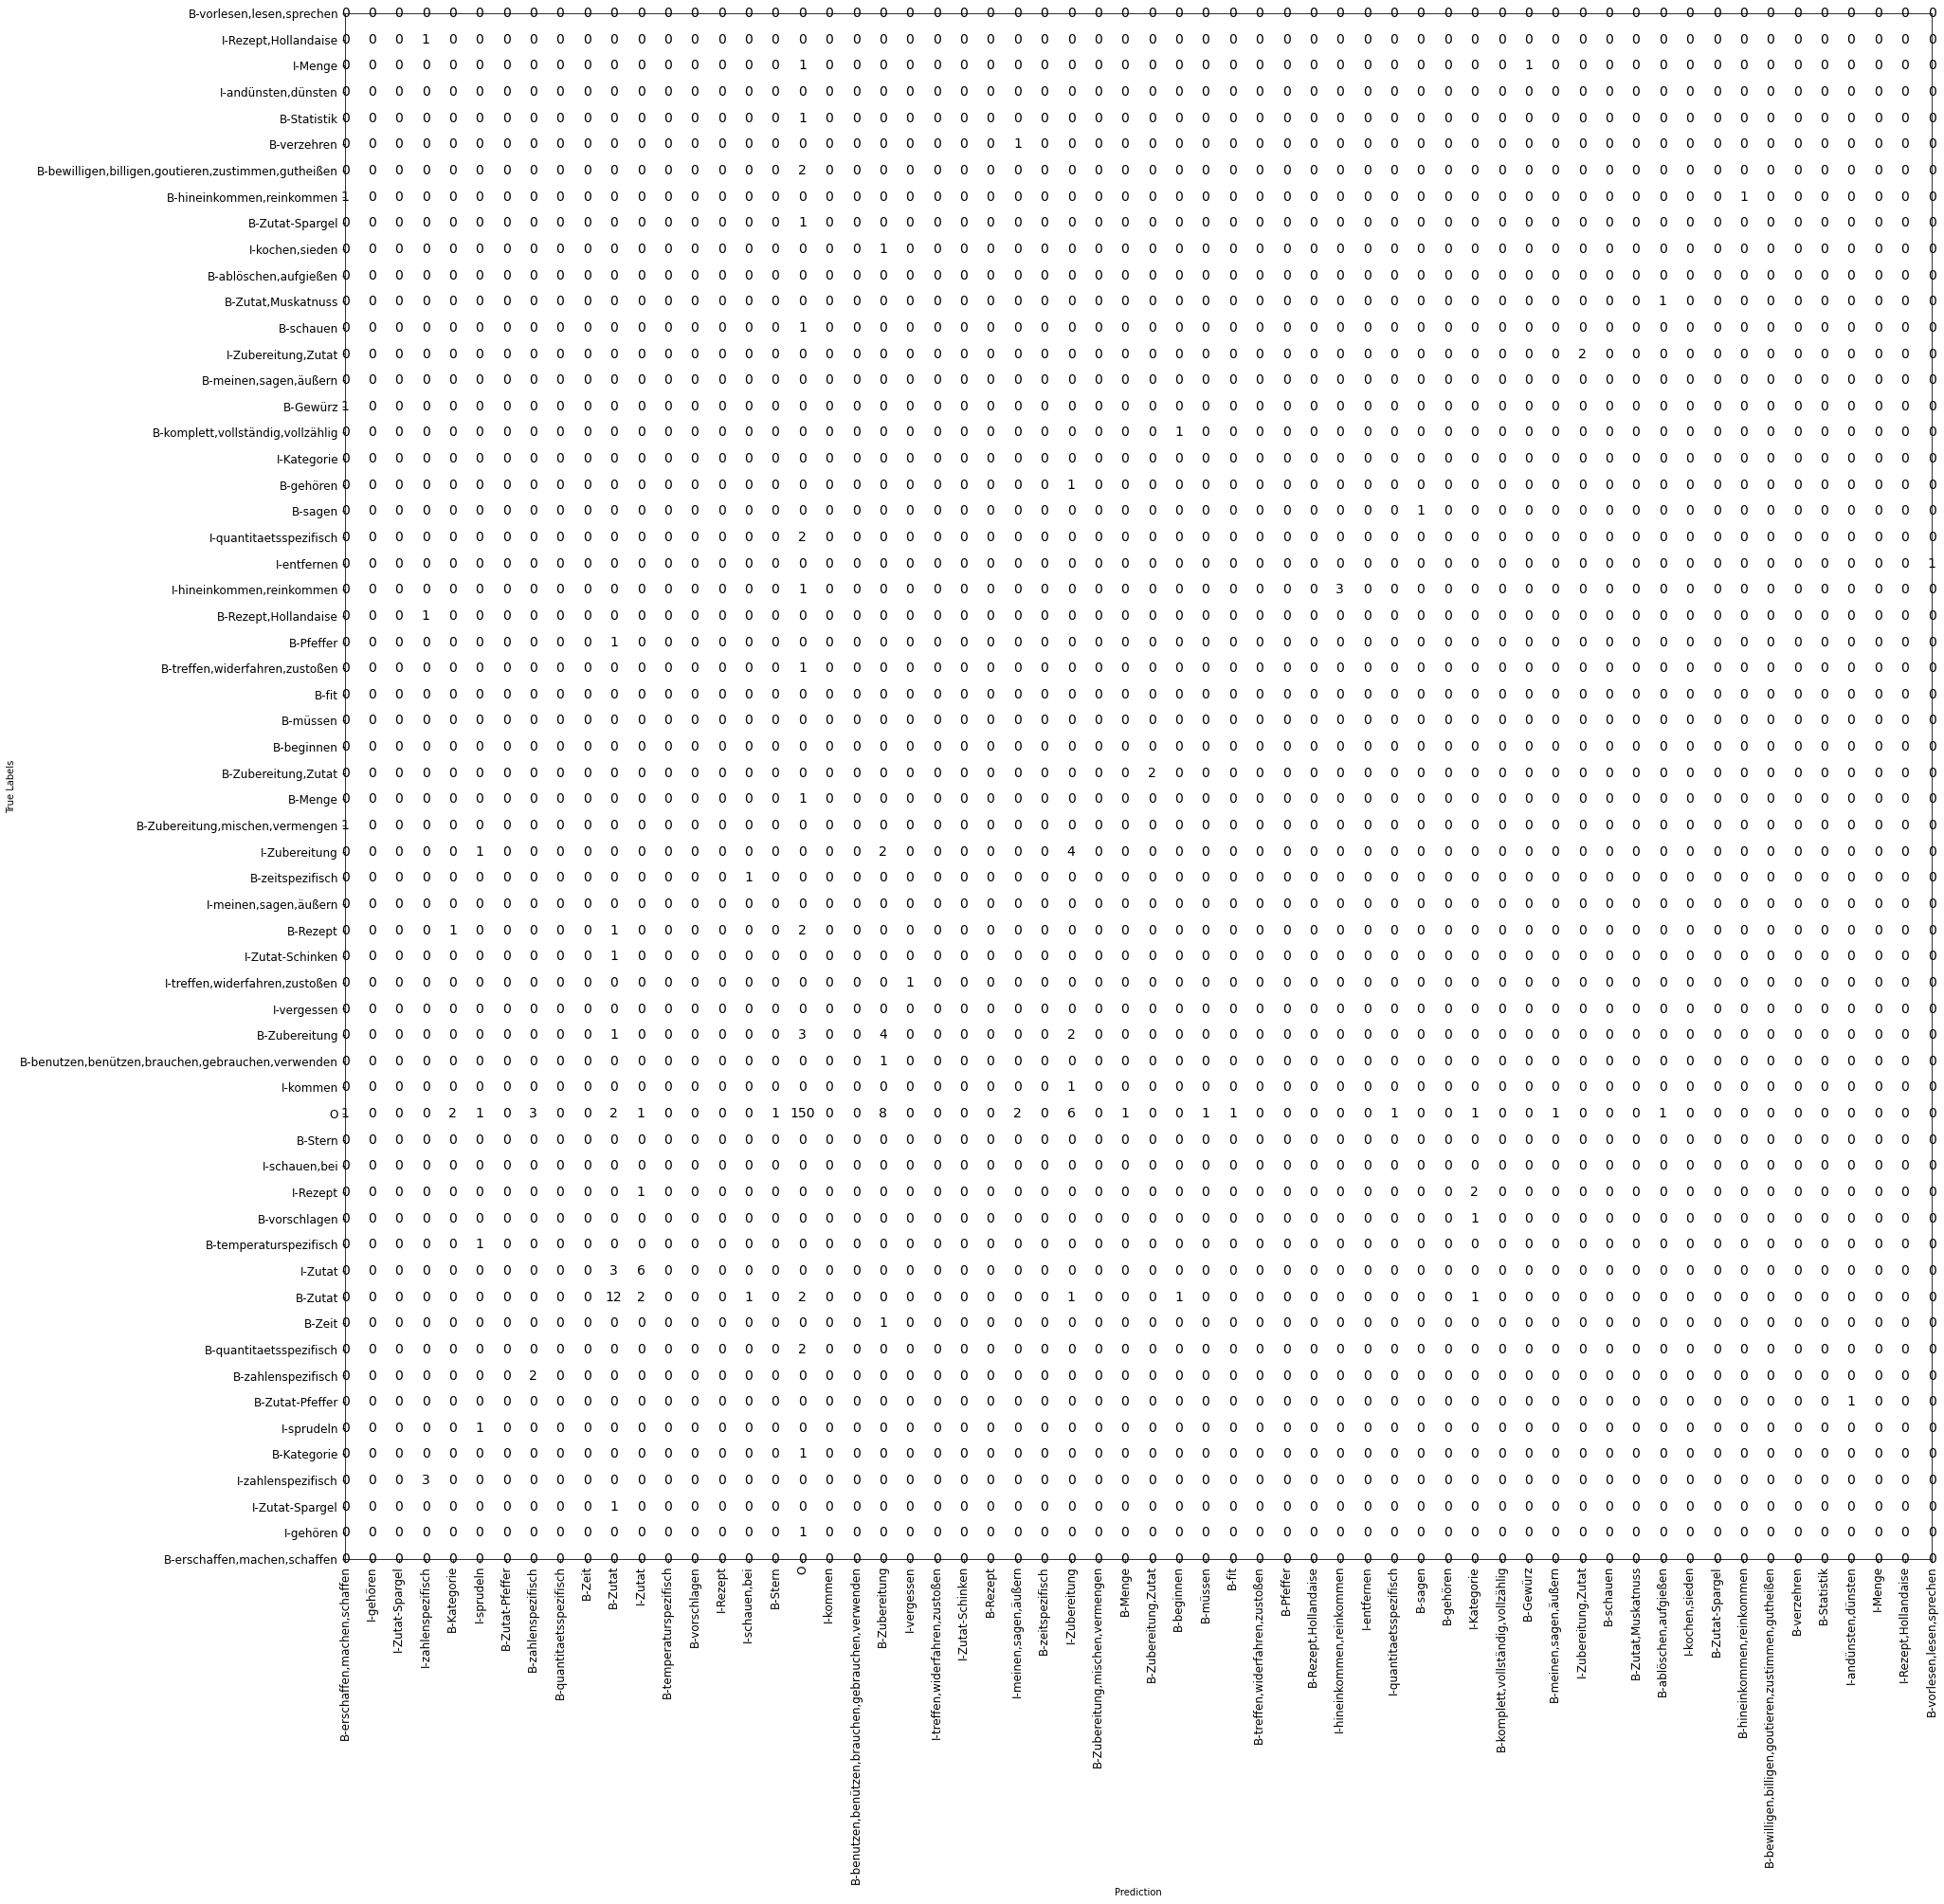

In [ ]:
plotConfusionMatrix(y, pred, 'plotAufgabe2')

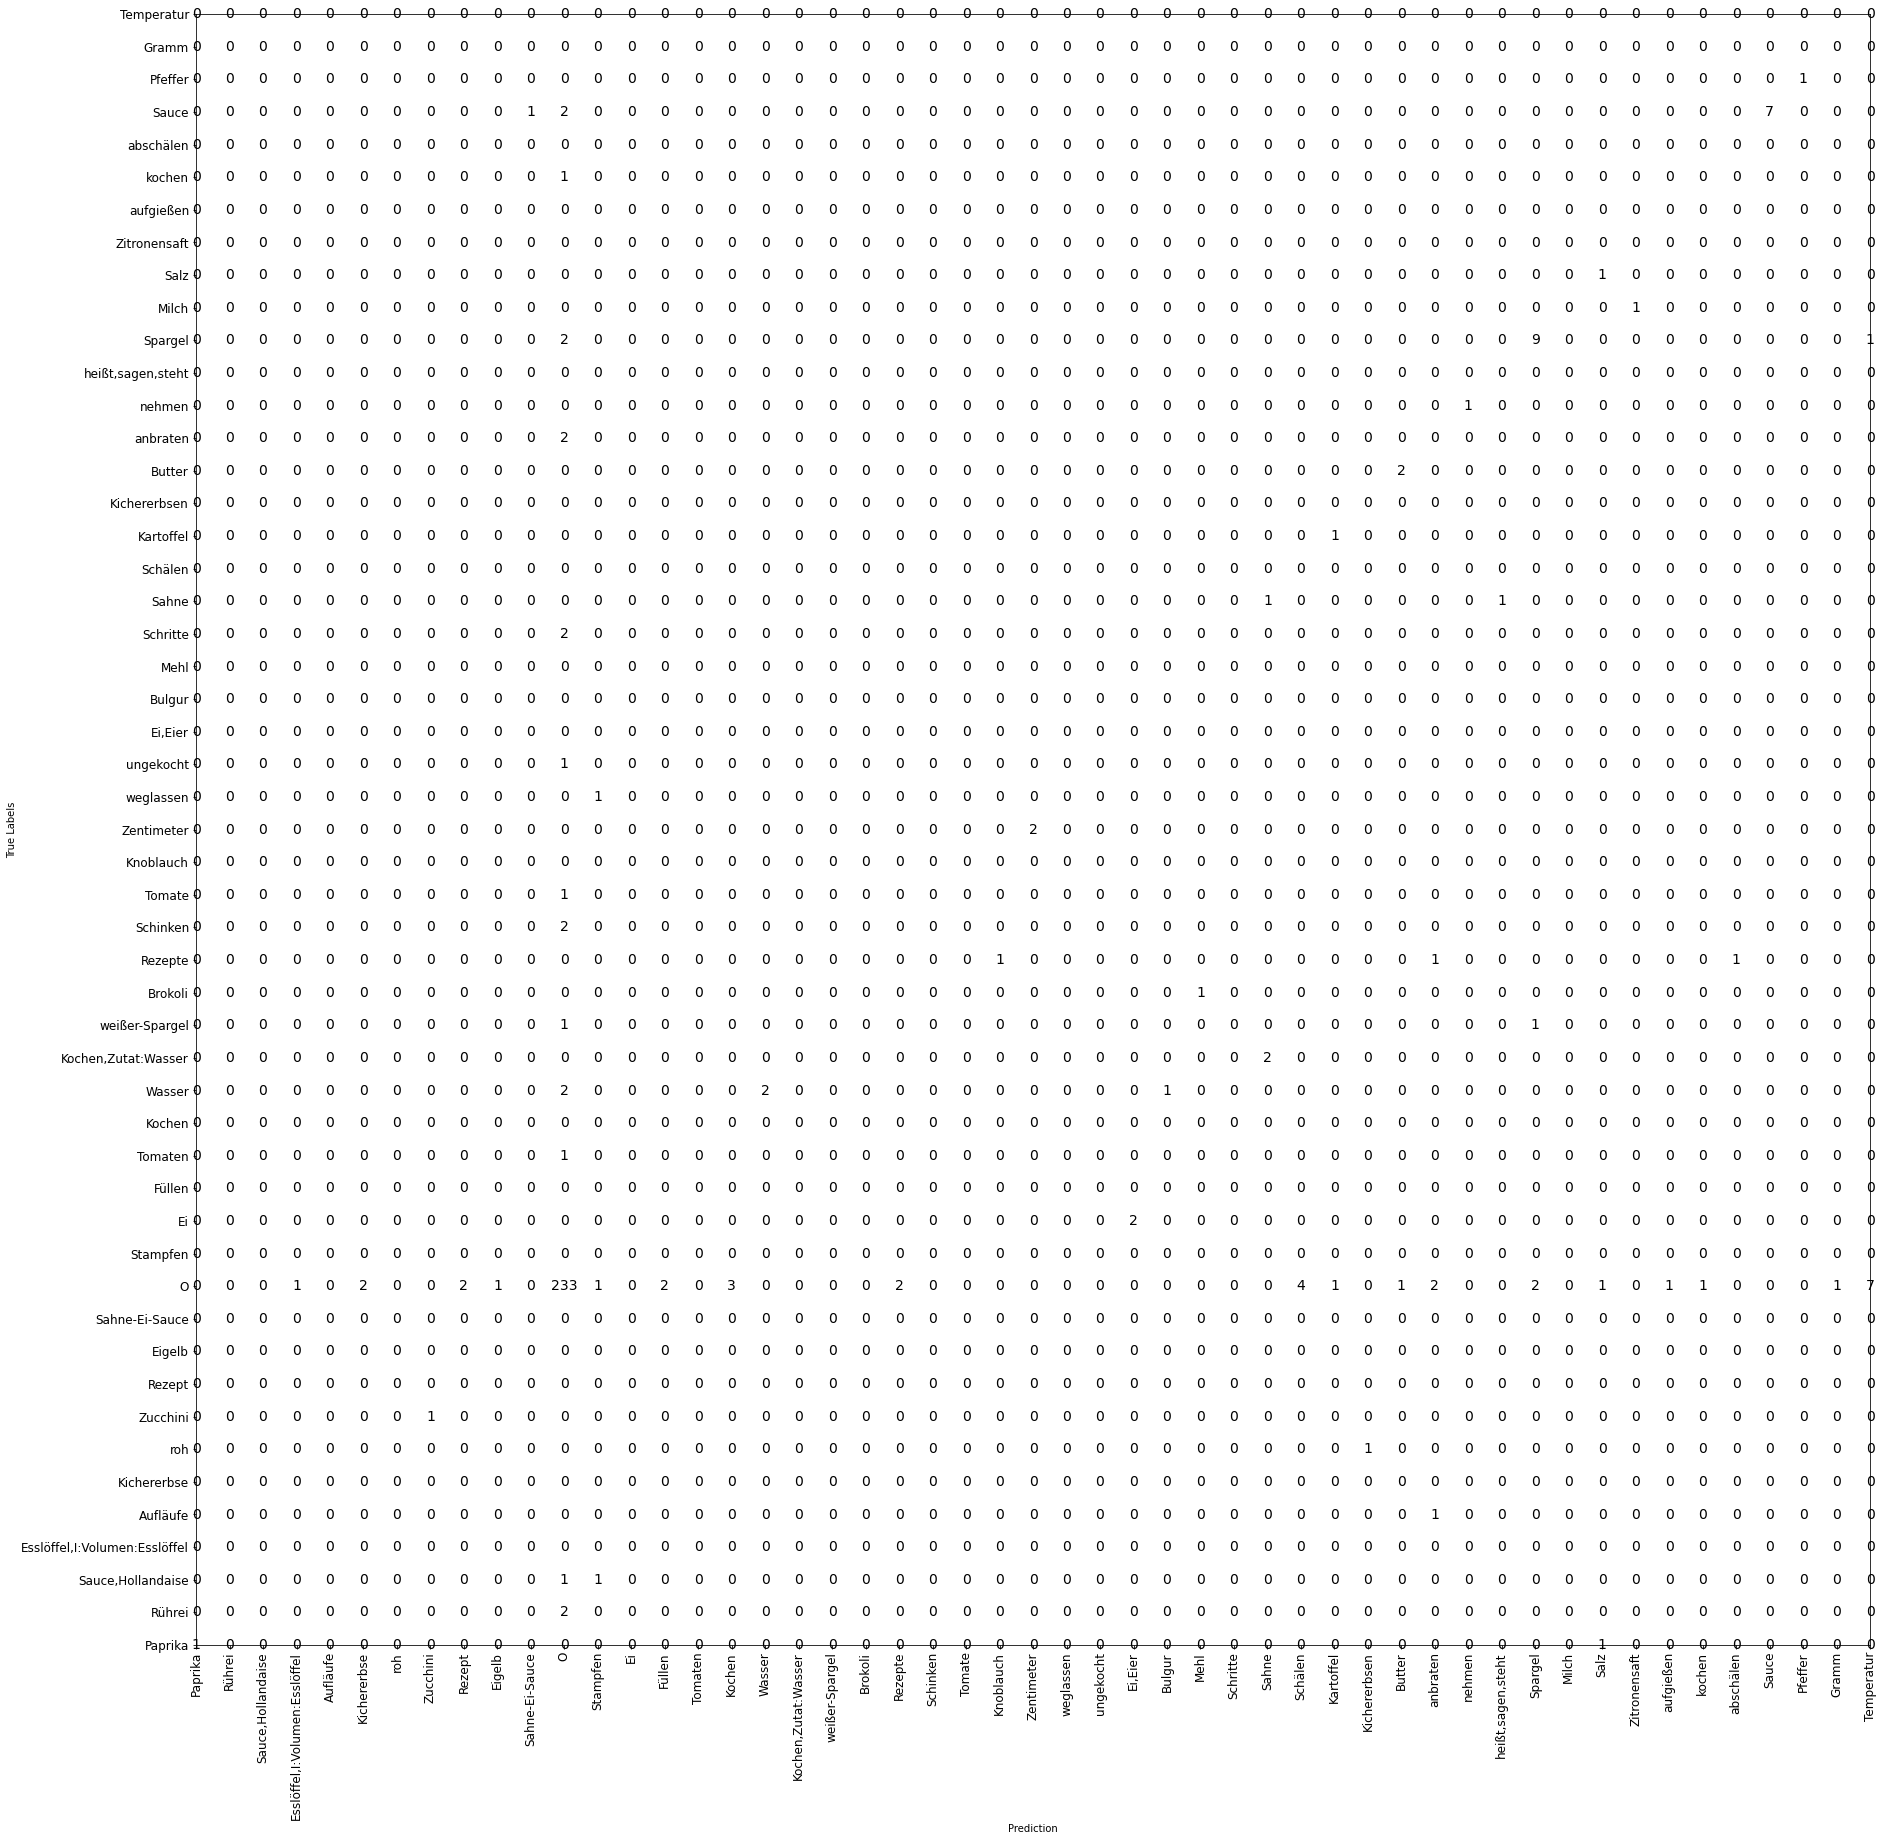

In [ ]:
plotConfusionMatrix(y2, pred2, 'plotAufgabe3')

In [ ]:
print(classification_report(y, pred))

                                                   precision    recall  f1-score   support

                                           Gewürz       0.00      0.00      0.00         1
                                        Kategorie       0.00      0.00      0.00         1
                                            Menge       0.00      0.00      0.00         1
                                          Pfeffer       0.00      0.00      0.00         1
                                           Rezept       0.00      0.00      0.00         4
                               Rezept,Hollandaise       0.00      0.00      0.00         1
                                        Statistik       0.00      0.00      0.00         1
                                            Stern       0.00      0.00      0.00         0
                                             Zeit       0.00      0.00      0.00         1
                                      Zubereitung       0.20      0.33      0.25        1

In [ ]:
print(classification_report(y2, pred2))

                              precision    recall  f1-score   support

                    Ei-Sauce       0.00      0.00      0.00         0
                     Spargel       0.00      0.00      0.00         1
                        ahne       0.33      0.50      0.40         2
                         alz       0.33      1.00      0.50         1
                      aprika       1.00      0.50      0.67         2
                    artoffel       0.50      1.00      0.67         1
                       asser       1.00      0.67      0.80         3
                        auce       1.00      0.70      0.82        10
            auce,Hollandaise       0.00      0.00      0.00         2
                    bschälen       0.00      0.00      0.00         0
                     chinken       0.00      0.00      0.00         2
                     chritte       0.00      0.00      0.00         2
                      chälen       0.00      0.00      0.00         0
                   